# Introduction

Factorization Machines (FM) - is a model used for classification, regression or ranking tasks. It was developed in 2010. It uses latent features of users/items.


Source: Factorization Machine models in PyTorch (https://github.com/rixwew/pytorch-fm)

In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from movie_lens_data import MovieLensData
from pt_layer import FactorizationMachine, FeaturesEmbedding, FeaturesLinear, MultiLayerPerceptron

# Read the data

In [3]:
path = "/kaggle/input/movielens-100k-dataset/ml-100k"
movie_lens_data = MovieLensData(
    users_path = os.path.join(path, "u.user"),
    ratings_path = os.path.join(path, "u.data"), 
    movies_path = os.path.join(path, "u.item"), 
    genre_path = os.path.join(path, "u.genre") 
    )

evaluation_data = movie_lens_data.read_ratings_data()
movie_data = movie_lens_data.read_movies_data()
popularity_rankings = movie_lens_data.get_popularity_ranks()
ratings = movie_lens_data.get_ratings()

# Prepare the dataset

In [4]:
class MovieLensDataset(torch.utils.data.Dataset):
    """
    MovieLens Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    """
    def __init__(self, ratings):
        data = ratings.copy().to_numpy()
        self.items = data[:, :2].astype(np.int32) - 1  # -1 because ID begins from 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.int64)
        self.item_field_idx = np.array((1,), dtype=np.int64)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target = target / 5.
        return target

In [5]:
def get_dataset():
    return MovieLensDataset(ratings)

# Prepare the algorithm  

## The model  

In [6]:
class FactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Factorization Machine.

    Reference:
        S Rendle, Factorization Machines, 2010.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = self.linear(x) + self.fm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

## Early stopper

In [7]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path, lower_is_better=True):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.lower_is_better = lower_is_better
        if self.lower_is_better:
            self.best_accuracy = 1_000_000
        else:
            self.best_accuracy = 0
        self.save_path = save_path

    def is_continuable(self, model, accuracy):
        print(f"ES accuracy: {accuracy}")
        if (self.lower_is_better and accuracy < self.best_accuracy) or\
           (not self.lower_is_better and accuracy > self.best_accuracy) :
            self.best_accuracy = accuracy
            self.trial_counter = 0
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False

## Get the model

In [8]:
def get_model(dataset):
    field_dims = dataset.field_dims
    return FactorizationMachineModel(field_dims, embed_dim=64) 

## Train

In [9]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    av_loss = []
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            loss = total_loss / log_interval
            av_loss.append(loss)
            tk0.set_postfix(loss=loss)
            total_loss = 0
    return np.mean(av_loss)   

## Test/validation

In [10]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return 5.* mean_squared_error(targets, predicts)

# Settings

In [11]:
device_cpu = "cpu"
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 64
epochs = 20
model_name = "DeepFM"
device = torch.device(device_cpu)

# Prepare train, valid & test datasets

In [12]:
dataset = get_dataset()
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

# Fit the model

In [13]:
model = get_model(dataset).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopper = EarlyStopper(num_trials=5, save_path=f'{model_name}.pt')

In [14]:
metric_values = []
loss_values = []

for epoch_i in range(epochs):
    loss = train(model, optimizer, train_data_loader, criterion, device)
    loss_values.append((epoch_i, loss))
    
    metric_valid = test(model, valid_data_loader, device)
    print('epoch:', epoch_i + 1, 'validation: mae:', metric_valid)
    
    metric_train = test(model, train_data_loader, device)
    print('train mae:', metric_train)
    
    metric_test = test(model, test_data_loader, device)
    print(f'test mae: {metric_test}')
    
    metric_values.append((epoch_i, metric_train, metric_valid, metric_test))
    
    if not early_stopper.is_continuable(model, metric_valid):
        print(f'validation: best mae: {early_stopper.best_accuracy}')
        break

100%|██████████| 157/157 [00:00<00:00, 359.70it/s]


epoch: 1 validation: mae: 0.33250261994524033


100%|██████████| 1250/1250 [00:02<00:00, 435.16it/s]


train mae: 0.3251075700126443


100%|██████████| 157/157 [00:00<00:00, 352.16it/s]


test mae: 0.3352178845424744
ES accuracy: 0.33250261994524033


100%|██████████| 157/157 [00:00<00:00, 345.39it/s]


epoch: 2 validation: mae: 0.2592391629264789


100%|██████████| 1250/1250 [00:02<00:00, 435.27it/s]


train mae: 0.249553239379139


100%|██████████| 157/157 [00:00<00:00, 343.03it/s]


test mae: 0.2611566592391922
ES accuracy: 0.2592391629264789


100%|██████████| 157/157 [00:00<00:00, 346.56it/s]


epoch: 3 validation: mae: 0.23018640143394897


100%|██████████| 1250/1250 [00:02<00:00, 421.52it/s]


train mae: 0.22140436719375994


100%|██████████| 157/157 [00:00<00:00, 339.23it/s]


test mae: 0.23204505204934228
ES accuracy: 0.23018640143394897


100%|██████████| 157/157 [00:00<00:00, 321.72it/s]


epoch: 4 validation: mae: 0.21462072871908877


100%|██████████| 1250/1250 [00:02<00:00, 435.57it/s]


train mae: 0.207296739127096


100%|██████████| 157/157 [00:00<00:00, 359.06it/s]


test mae: 0.21646137168658564
ES accuracy: 0.21462072871908877


100%|██████████| 157/157 [00:00<00:00, 335.87it/s]


epoch: 5 validation: mae: 0.2039806406553541


100%|██████████| 1250/1250 [00:02<00:00, 432.28it/s]


train mae: 0.198087032301026


100%|██████████| 157/157 [00:00<00:00, 302.32it/s]


test mae: 0.2058745201566174
ES accuracy: 0.2039806406553541


100%|██████████| 157/157 [00:00<00:00, 342.99it/s]


epoch: 6 validation: mae: 0.1963502199900319


100%|██████████| 1250/1250 [00:02<00:00, 431.64it/s]


train mae: 0.19155408735961948


100%|██████████| 157/157 [00:00<00:00, 370.59it/s]


test mae: 0.1982924245662668
ES accuracy: 0.1963502199900319


100%|██████████| 157/157 [00:00<00:00, 327.54it/s]


epoch: 7 validation: mae: 0.19121663998909896


100%|██████████| 1250/1250 [00:03<00:00, 406.42it/s]


train mae: 0.1871097837898754


100%|██████████| 157/157 [00:00<00:00, 348.41it/s]


test mae: 0.19323745282378862
ES accuracy: 0.19121663998909896


100%|██████████| 157/157 [00:00<00:00, 346.77it/s]


epoch: 8 validation: mae: 0.1880034734212056


100%|██████████| 1250/1250 [00:02<00:00, 443.43it/s]


train mae: 0.18425458891674312


100%|██████████| 157/157 [00:00<00:00, 344.71it/s]


test mae: 0.19015159976010484
ES accuracy: 0.1880034734212056


100%|██████████| 157/157 [00:00<00:00, 340.60it/s]


epoch: 9 validation: mae: 0.18603541275255764


100%|██████████| 1250/1250 [00:03<00:00, 408.37it/s]


train mae: 0.18240478218190959


100%|██████████| 157/157 [00:00<00:00, 346.59it/s]


test mae: 0.18828905200389626
ES accuracy: 0.18603541275255764


100%|██████████| 157/157 [00:00<00:00, 324.59it/s]


epoch: 10 validation: mae: 0.18485466424054997


100%|██████████| 1250/1250 [00:02<00:00, 422.54it/s]


train mae: 0.1812270982922487


100%|██████████| 157/157 [00:00<00:00, 336.77it/s]


test mae: 0.18716787868549334
ES accuracy: 0.18485466424054997


100%|██████████| 157/157 [00:00<00:00, 323.75it/s]


epoch: 11 validation: mae: 0.1841576385010681


100%|██████████| 1250/1250 [00:02<00:00, 420.75it/s]


train mae: 0.18051218296173432


100%|██████████| 157/157 [00:00<00:00, 331.43it/s]


test mae: 0.18650697852761805
ES accuracy: 0.1841576385010681


100%|██████████| 157/157 [00:00<00:00, 359.21it/s]


epoch: 12 validation: mae: 0.18372041070668937


100%|██████████| 1250/1250 [00:02<00:00, 419.72it/s]


train mae: 0.18005029974004527


100%|██████████| 157/157 [00:00<00:00, 330.11it/s]


test mae: 0.18609099037964938
ES accuracy: 0.18372041070668937


100%|██████████| 157/157 [00:00<00:00, 346.35it/s]


epoch: 13 validation: mae: 0.1834314877892435


100%|██████████| 1250/1250 [00:02<00:00, 429.88it/s]


train mae: 0.17974544525171446


100%|██████████| 157/157 [00:00<00:00, 328.17it/s]


test mae: 0.18581713863838278
ES accuracy: 0.1834314877892435


100%|██████████| 157/157 [00:00<00:00, 335.23it/s]


epoch: 14 validation: mae: 0.1832384396595001


100%|██████████| 1250/1250 [00:03<00:00, 388.72it/s]


train mae: 0.17953528020378978


100%|██████████| 157/157 [00:00<00:00, 347.33it/s]


test mae: 0.18563092893583957
ES accuracy: 0.1832384396595001


100%|██████████| 157/157 [00:00<00:00, 330.79it/s]


epoch: 15 validation: mae: 0.18310953034188224


100%|██████████| 1250/1250 [00:02<00:00, 423.32it/s]


train mae: 0.17939811773654488


100%|██████████| 157/157 [00:00<00:00, 335.58it/s]


test mae: 0.18550990421893182
ES accuracy: 0.18310953034188224


100%|██████████| 157/157 [00:00<00:00, 336.33it/s]


epoch: 16 validation: mae: 0.18302330702006842


100%|██████████| 1250/1250 [00:03<00:00, 413.68it/s]


train mae: 0.17930491546702926


100%|██████████| 157/157 [00:00<00:00, 332.35it/s]


test mae: 0.18542435749617325
ES accuracy: 0.18302330702006842


100%|██████████| 157/157 [00:00<00:00, 328.26it/s]


epoch: 17 validation: mae: 0.1829643951946988


100%|██████████| 1250/1250 [00:03<00:00, 403.21it/s]


train mae: 0.17924110576825925


100%|██████████| 157/157 [00:00<00:00, 331.48it/s]


test mae: 0.1853652190230815
ES accuracy: 0.1829643951946988


100%|██████████| 157/157 [00:00<00:00, 316.21it/s]


epoch: 18 validation: mae: 0.1829231008900929


100%|██████████| 1250/1250 [00:03<00:00, 412.38it/s]


train mae: 0.17919696581683106


100%|██████████| 157/157 [00:00<00:00, 336.99it/s]


test mae: 0.18532381086867372
ES accuracy: 0.1829231008900929


100%|██████████| 157/157 [00:00<00:00, 347.56it/s]


epoch: 19 validation: mae: 0.18289421251636673


100%|██████████| 1250/1250 [00:02<00:00, 441.45it/s]


train mae: 0.17916546775423747


100%|██████████| 157/157 [00:00<00:00, 350.95it/s]


test mae: 0.18529356830266086
ES accuracy: 0.18289421251636673


100%|██████████| 157/157 [00:00<00:00, 344.67it/s]


epoch: 20 validation: mae: 0.18287497121003232


100%|██████████| 1250/1250 [00:02<00:00, 422.23it/s]


train mae: 0.17914550226995593


100%|██████████| 157/157 [00:00<00:00, 316.22it/s]

test mae: 0.18527399813515538
ES accuracy: 0.18287497121003232


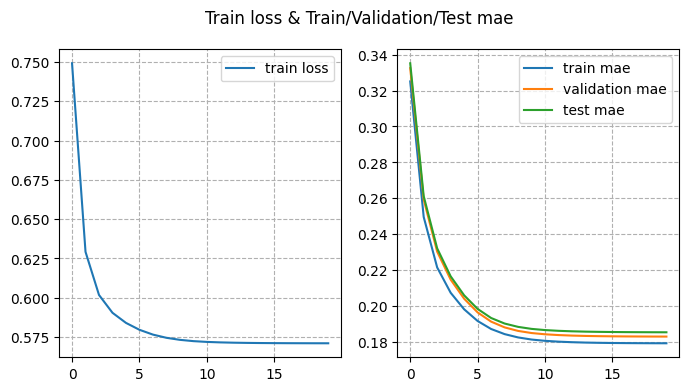

In [15]:
from matplotlib import pyplot as plt
metric_values = np.array(metric_values)
loss_values = [x[1] for x in loss_values]
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(loss_values, label="train loss")
ax[0].legend()
ax[0].grid(linestyle="--",which="major")

ax[1].plot(metric_values[:, 1], label="train mae")
ax[1].plot(metric_values[:, 2], label="validation mae")
ax[1].plot(metric_values[:, 3], label="test mae")
ax[1].legend()
ax[1].grid(linestyle="--",which="major")
plt.suptitle("Train loss & Train/Validation/Test mae")
plt.show()